## Introducing our research question / plan

plan inspiration : "Impact Profiles — a geodemographic classification of London neighbourhoods based on how they have, or have not, been impacted by Airbnb. This would require you to think about how to develop a classification/clustering of London neighbourhoods and use data to develop ‘pen portraits’ of each so that policy-makers could better-understand the range of environments in which Airbnb operates and why a 1-size-fits-all regulatory approach may be insufficient. Again, this could be argued from either standpoint or even both simultaneously: these areas are already so heavily impacted that regulation is too little, too late, while these other areas are ‘at risk’."

*introduce research surrounding the negative impact of airbnb on neighbourhoods - as justification for identifying at risk wards + a neighbourhood-first approach for policies

research question ideas:

What wards are at risk of becoming an airbnb hotspot? and which are too late?

what are the socioeconomic characteristics of these 'at-risk' wards - do their populations tend to be more vulnerable? 

blah blah 

ChatGPT summaries:
"Negative Impacts of Airbnb
Research highlights how Airbnb affects neighborhoods, including:

Rising Housing Costs: Increased demand for short-term rentals inflates property prices and rental rates.
Community Displacement: Permanent residents are often priced out or displaced as homes convert to Airbnbs.
Strain on Local Infrastructure: High Airbnb density areas often face overcrowded transport and services.
These impacts underscore the need for a neighborhood-first policy approach, as a one-size-fits-all solution may overlook unique local dynamics.

Why Identify At-Risk Wards?
By profiling wards before they become hotspots, policymakers can:

Implement preemptive measures (e.g., zoning regulations or Airbnb caps).
Protect affordabble housing and community cohesion in areas with high vulnerability.
Simultaneously, identifying too-late wards informs where reactive policies are needed to mitigate ongoing damage"

"Why Focus on "At-Risk" and "Too-Late" Wards?
Research highlights that Airbnb's negative impacts include:

Housing Market Strain: Reduced housing availability and affordability due to the shift from long-term rentals to short-term Airbnb lets.
Neighbourhood Character Disruption: Over-tourism and loss of local identity in high-density Airbnb areas.
Unequal Impacts: Different areas experience varying levels of disruption, underscoring the need for targeted policies.
A neighbourhood-first approach recognizes these spatial inequalities, ensuring policies address local needs. By identifying "at-risk" wards, policymakers can implement preventative measures, while understanding "too-late" wards can guide recovery-focused strategies."

---> which borough/boroughs to focus resources on?


why we chose the variables we did:
https://www.sciencedirect.com/science/article/abs/pii/S0264275119306559?via%3Dihub <- paper Hania found

+ describe the units ? what does a public transport accessibility score mean?

why we chose ward scale

why we chose this method (decision tree)
method :
We used a Decision Tree Classifier to categorise London wards into three groups:

Too Late: Wards already heavily impacted by Airbnb, that are in the top 5% of airbnb's per 1000 households. 
At Risk: Wards with similar characteristics to high Airbnb density wards but are not yet heavily impacted.
Neither: Wards that don't fall into either category.
The decision tree predicts whether a ward is likely to have a high Airbnb density based on ward-level characteristics: public transport accessibility, house prices, and point of interest density. Wards that are predicted to have high density but currently don’t are classified as at-risk.

chosen because: interpretable, simplicity , feature relevance, how it works . #gonna expand on this obvs

One of the key benefits of a decision tree is their interpretability by non-technical audiences. Each classification decision the model makes can be easily traced in a simple, visual format.

#### Importing Packages

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats


#### Reading in data


In [2]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

airbnb.head(2)

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,1126718007114818432,https://www.airbnb.com/rooms/1126718007114818431,2024-06-14,Cozy house in Northolt,Located 1 minute away from a bus stop and 10 m...,380326752,Sadikshya,2020-12-15,NaN,False,...,48.0,3,365,269,0,NaN,NaN,NaN,NaN,POINT (511486.571 183013.675)
1,702589406864297984,https://www.airbnb.com/rooms/702589406864297985,2024-06-15,Up in the sky in London!,"One bedroom with double bed, desk and with th...",77760754,Lena,2016-06-14,"London, United Kingdom",True,...,42.0,1,365,146,83,2023-08-30,2024-06-13,4.94,8.56,POINT (536178.811 185752.509)


Filtering airbnb data:

what we did and justification .. ..  



In [3]:
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

In [4]:
##--London Ward Profiles--##

ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

#including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]

ward_profiles.head(2)

,Ward name,New code,Average Public Transport Accessibility score - 2014,Median House Price (£) - 2014,Median Household income estimate (2012/13),(ID2010) - Rank of average score (within London) - 2010,(ID2010) % of LSOAs in worst 50% nationally - 2010,Average GCSE capped point scores - 2014,% BAME - 2011,Number of Household spaces - 2011
0,City of London,E09000001,7.9,765000.0,63620.0,551.0,20.0,354.5,21.4,5530
1,Barking and Dagenham - Abbey,E05000026,6.0,173000.0,33920.0,166.0,85.7,317.7,71.9,4753


In [24]:
##--Wards Geometry Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]



,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


In [6]:
##--Point of Interest Data--##
##Selecting pubs, restaurants, cafes

gpkg_path = "data/London_Points_Of_Interest.gpkg"

# Read the GeoPackage into a GeoDataFrame
gdf = gpd.read_file(gpkg_path)

# Define the list of desired classnames
desired_classes = ["Pubs, Bars and Inns", "Cafes, Snack Bars and Tea Rooms", "Restaurants"]

# Filter the GeoDataFrame
poi_data = gdf[gdf['classname'].isin(desired_classes)]

poi_data.head(3)

,id,ref_no,name,pointx_class,groupname,categoryname,classname,feature_easting,feature_northing,pos_accuracy,...,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,geometry
6682,8137,19521780,Heston West Service Area,01020043,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,511446.0,177847.0,1,...,TW5 9NA,Hounslow London Borough,None,www.moto-way.com,Moto Hospitality Limited,Restaurant Type,Roadside,Moto,2024-09-01,POINT (511446 177847)
6685,8142,19521779,Heston East Service Area,01020043,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,512027.0,177854.0,1,...,TW5 9NA,Hounslow London Borough,None,www.moto-way.com,Moto Hospitality Limited,Restaurant Type,Roadside,Moto,2024-09-01,POINT (512027 177854)
6703,8167,18857214,Welcome Break (London Gateway),01020043,"Accommodation, Eating and Drinking",Eating and Drinking,Restaurants,520246.0,193914.0,1,...,NW7 3HU,Barnet London Borough,None,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,2024-09-01,POINT (520246 193914)


#### Merging together

In [7]:
ward_airbnb = wards.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

ward_airbnb = gpd.GeoDataFrame(ward_airbnb, crs = "EPSG:27700")

ward_airbnb['Borough'] = ward_airbnb['Ward name'].str.split(' - ').str[0]

#creating poi_density variable
ward_airbnb["n_poi"] = ward_airbnb.geometry.apply(lambda geom: sum(poi_data.geometry.intersects(geom)))
ward_airbnb["poi_density"] = ward_airbnb["n_poi"] / ward_airbnb["HECTARES"]

#intersecting airbnb points and ward data 
#creating airbnb per 1000 households variables
ward_airbnb["n_airbnb"] = ward_airbnb.geometry.apply(lambda geom: sum(filtered_airbnb.geometry.intersects(geom)))
ward_airbnb["airbnb_density"] = ward_airbnb["n_airbnb"] / ward_airbnb["HECTARES"]
#ward_airbnb["airbnb_per_1000"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Population - 2015"])*1000
ward_airbnb["airbnb_per_1000_household"] = (ward_airbnb["n_airbnb"] / ward_airbnb["Number of Household spaces - 2011"])*1000


#### Mapping Airbnb per 1000 households


<Axes: >

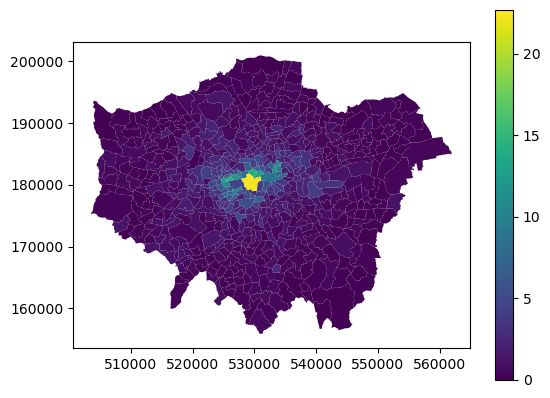

In [8]:
ward_airbnb.plot(column = "airbnb_per_1000_household", cmap="viridis", legend = True)

**to do**: describe concentration of airbnb's on map - airbnb's clustered in the centre of London

### Decision Tree Model

In [9]:
# Calculate the 95th quantile for Airbnb density
quantile = np.quantile(ward_airbnb['airbnb_per_1000_household'], 0.95)
print(f"95th quantile: {quantile}")

# Create a high Airbnb density indicator
ward_airbnb['high_airbnb_dens'] = ward_airbnb['airbnb_per_1000_household'] >= quantile

95th quantile: 5.628932432591062


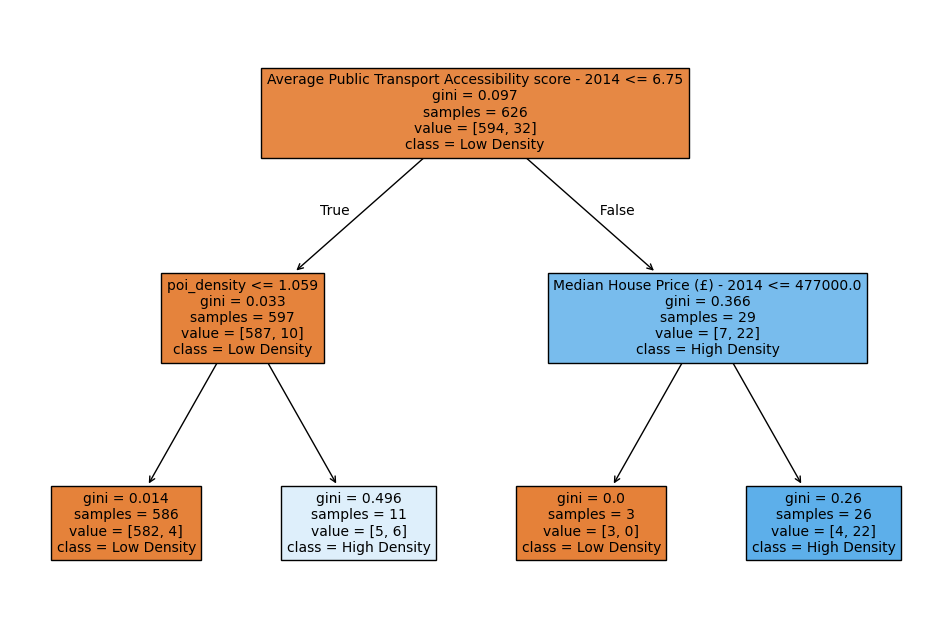

In [10]:
# Prepare data for the decision tree
X = ward_airbnb[['poi_density', 
                 'Average Public Transport Accessibility score - 2014', 
                 'Median House Price (£) - 2014', 
                 'Median Household income estimate (2012/13)']]  # dependent variables
y = ward_airbnb['high_airbnb_dens']

# Train a decision tree
tree = DecisionTreeClassifier(max_depth=2, random_state=42) # limited depth means model remains interpretable without overfitting, focusing on the most critical features.
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Low Density', 'High Density'], filled=True, fontsize=10)
plt.show()

#### Interpreting the Decision Tree !

The model predicts a ward to be have a high airbnb density under two scenarios:

Transport Accessibility of more than 6.75 and a Median House Price of more than £477,000 
**or**
Transport Accessibility of less than or equal to 6.75 and a point of interest density of more than 1.059 per hectare. 

thoughts: (what does a score of 6.75 mean? how does it compare to average)

Feature importance: suggests that Public Transport accessibility is most important feature for classifying wards into low and high density.


What is the accuracy of this model?

In [11]:
from sklearn.metrics import confusion_matrix

ward_airbnb['predicted_high_airbnb_dens'] = tree.predict_proba(X)[:, 1] > 0.5

# Create a confusion matrix
conf_matrix = confusion_matrix(
    ward_airbnb['high_airbnb_dens'], 
    ward_airbnb['predicted_high_airbnb_dens'], 
    labels=[True, False]
)

# Display confusion matrix as a pandas DataFrame for readability
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=['True Positive (Reality: High Airbnb)', 'True Negative (Reality: Low Airbnb)'], 
    columns=['Predicted High Airbnb', 'Predicted Low Airbnb']
)

print(conf_matrix_df)

TP = conf_matrix[1, 1]  # True Positives
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
FN = conf_matrix[1, 0]  # False Negatives

accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy2 = (TN) / (TN + FN)

print(f"\nAccuracy: {accuracy:.2f}")
print(f"High Airbnb Accuracy: {accuracy2:.2f}")

                                      Predicted High Airbnb  \
True Positive (Reality: High Airbnb)                     28   
True Negative (Reality: Low Airbnb)                       9   

                                      Predicted Low Airbnb  
True Positive (Reality: High Airbnb)                     4  
True Negative (Reality: Low Airbnb)                    585  

Accuracy: 0.98
High Airbnb Accuracy: 0.76


Overall model accuracy is high for a simple model. 95%!

For predicting high airbnb density the model is less accurate at 76%, correctly predicting 28/32 high airbnb dense wards and miscategorising 9 non-high airbnb dense wards as high-density.

However, the 9 wards that the model miscategorised as Airbnb dense we can classify as at-risk, as they share similar characteristics to high-density wards.


In [12]:
# Add predictions to the GeoDataFrame
ward_airbnb['prediction'] = tree.predict_proba(X)[:, 1] > 0.5

# Generate the at-risk and too-late categories
at_risk = ward_airbnb[(ward_airbnb['high_airbnb_dens'] == False) & (ward_airbnb['prediction'] == True)]
too_late = ward_airbnb[ward_airbnb['high_airbnb_dens'] == True]

ward_airbnb['status'] = 'neither'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(too_late['Ward name']), 'status'] = 'too_late'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(at_risk['Ward name']), 'status'] = 'at_risk'


ward_names = at_risk['Ward name'].tolist()
print(f"These at-risk wards are: {', '.join(ward_names)}")


These at-risk wards are: Lambeth - Bishop's, Hammersmith and Fulham - Shepherd's Bush Green, Westminster - Vincent Square, Westminster - Warwick, Camden - Camden Town with Primrose Hill, Islington - St. Mary's, Islington - Bunhill, Islington - Finsbury Park, Hackney - Dalston


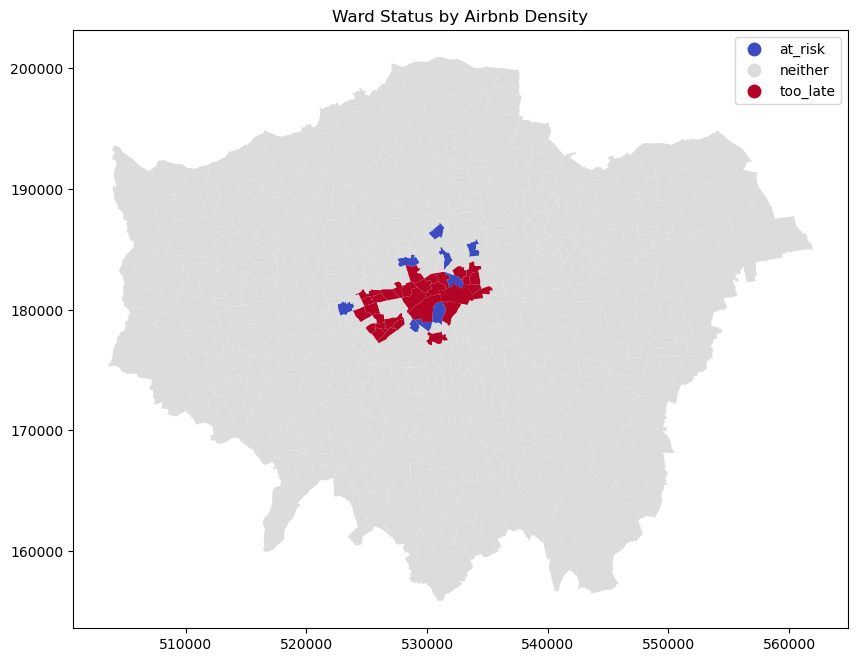

In [13]:

# Visualise with a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ward_airbnb.plot(column='status', 
                 legend=True, 
                 cmap='coolwarm', 
                 ax=ax, 
                 legend_kwds={'bbox_to_anchor': (1, 1)})
plt.title("Ward Status by Airbnb Density")
plt.show()

#### Analysing at risk wards

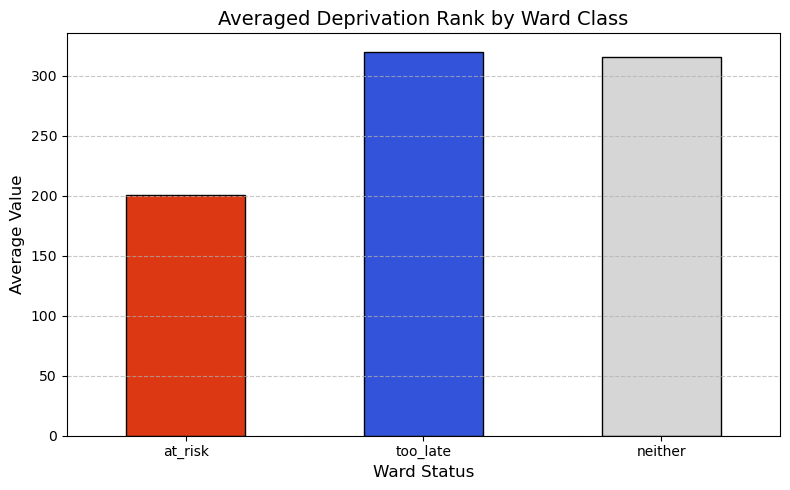

In [14]:
# List of variables to analyze
variables = [
    '(ID2010) - Rank of average score (within London) - 2010'#,
    #'(ID2010) % of LSOAs in worst 50% nationally - 2010',
    #'Median Household income estimate (2012/13)',
    #'Average GCSE capped point scores - 2014',
    #'% BAME - 2011'
]

# Custom order for the categories
category_order = ['at_risk', 'too_late', 'neither']

# Group the data by 'status' and calculate medians
#averages = ward_airbnb.groupby('status')[variables].median()
averages = ward_airbnb.groupby('status')[variables].mean()

# Reindex to ensure the correct order of categories
averages = averages.reindex(category_order)

# Create individual bar plots for each variable
for var in variables:
    plt.figure(figsize=(8, 5))
    averages[var].plot(kind='bar', color=['#dd3814', '#3354da', '#d6d6d6'], edgecolor='black')

    # Customize the plot
    plt.title(f'Averaged Deprivation Rank by Ward Class', fontsize=14)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Ward Status', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

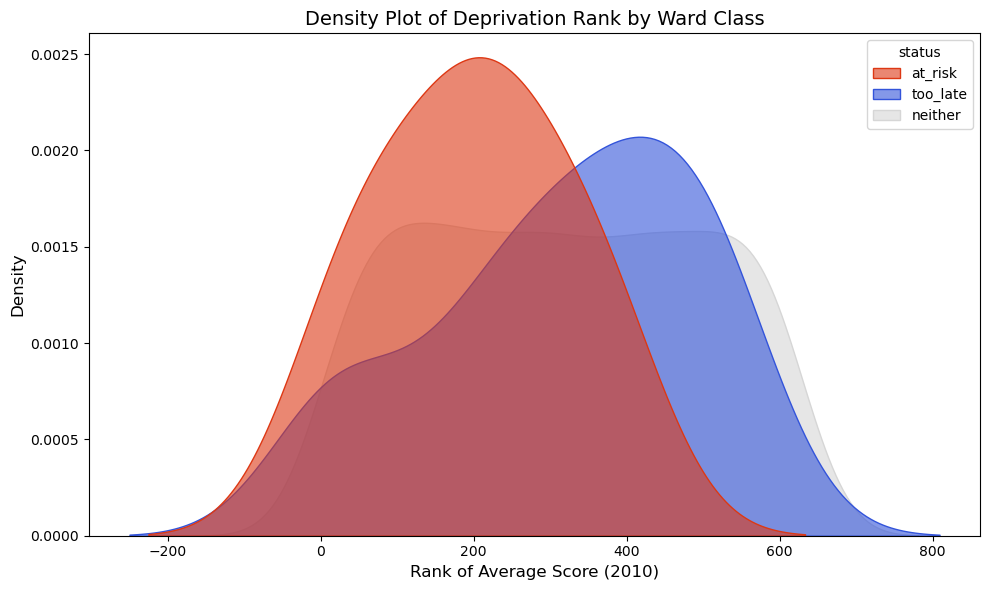

In [15]:
# Reorder the statuses
status_order = ['at_risk', 'too_late', 'neither']

plt.figure(figsize=(10, 6))

# Create density plot for each status with the same scale
sns.kdeplot(data=ward_airbnb, 
            x='(ID2010) - Rank of average score (within London) - 2010', 
            hue='status', 
            hue_order=status_order,  # Set the custom order for statuses
            fill=True, 
            common_norm=False,  # Normalize each density individually
            palette=['#dd3814', '#3354da', '#d6d6d6'],  # Custom color palette
            alpha=0.6)  # Transparency for the fill

# Customize the plot
plt.title('Density Plot of Deprivation Rank by Ward Class', fontsize=14)
plt.xlabel('Rank of Average Score (2010)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [16]:
##Chi^2 (not significant)

# Filter dataset to include only 'at_risk' and 'too_late' categories (excluding 'neither')
ward_airbnb_filtered = ward_airbnb[ward_airbnb['status'].isin(['at_risk', 'too_late'])]

# Create a contingency table between 'status' and 'deprivation_category'
contingency_table = pd.crosstab(ward_airbnb_filtered['status'], ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 41.0
P-value: 0.382868189120542
Degrees of Freedom: 39


/tmp/ipykernel_5246/3242406582.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(ward_airbnb)


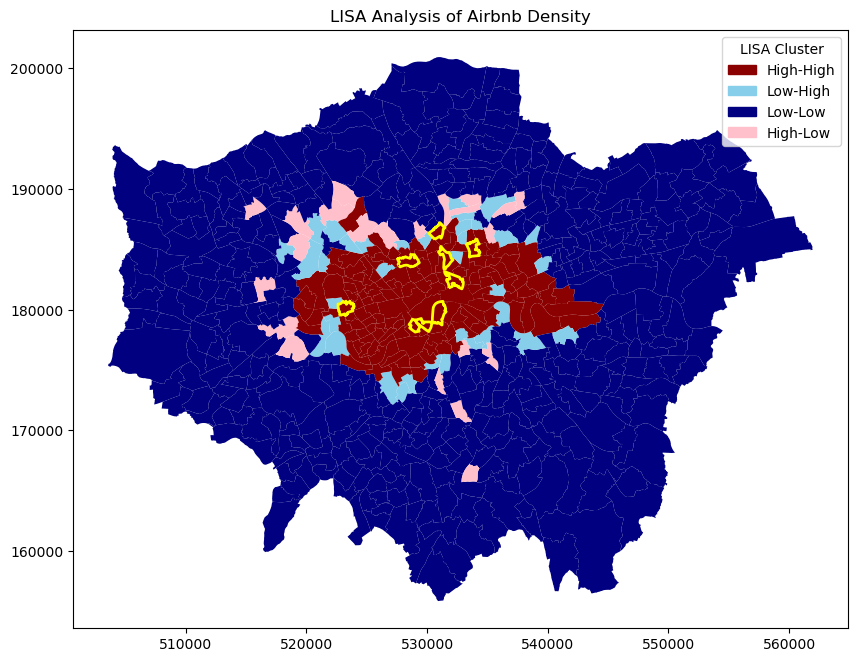

In [17]:
## LISA Analysis: Airbnb Density

from libpysal.weights import Queen
from esda import Moran_Local
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap



# Generate spatial weights matrix using Queen contiguity
w = Queen.from_dataframe(ward_airbnb)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the airbnb density variable for LISA analysis
y = ward_airbnb['airbnb_per_1000_household'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['darkred', 'skyblue', 'navy', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)


# Outline the wards with 'at_risk' status
at_risk_wards = ward_airbnb[ward_airbnb['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Airbnb Density')
plt.show()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


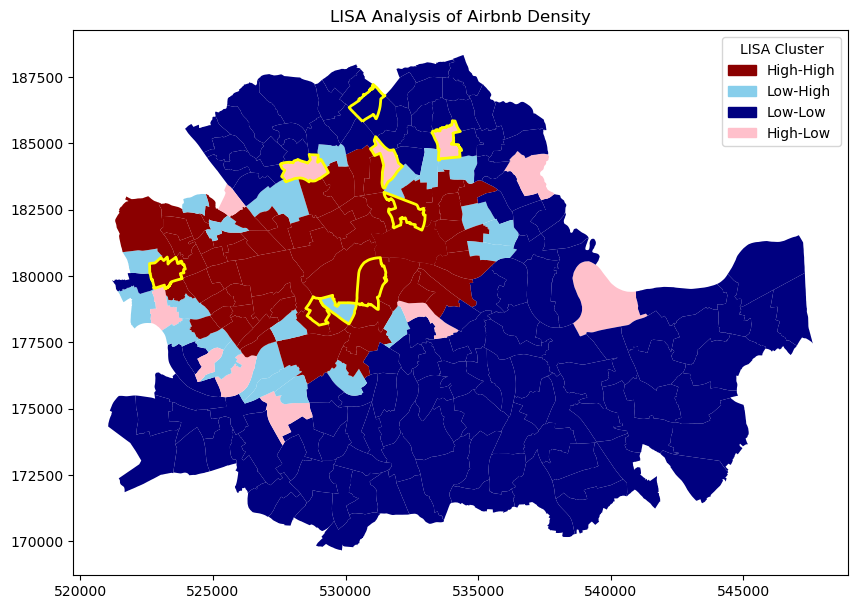

In [38]:
## Inner London LISA Analysis: Density
from libpysal import weights



# Filter the dataset to include only inner London boroughs
inner_london_wards = ward_airbnb[ward_airbnb['Borough'].isin(inner_london_boroughs)]

# Create a spatial weights matrix based on Queen contiguity
w = weights.Queen.from_dataframe(inner_london_wards, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = inner_london_wards['airbnb_per_1000_household'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Run Local Moran's I for Airbnb density
#local_moran = esda.Moran_Local(inner_london_wards['airbnb_per_1000_household'], w)

# Add the LISA statistics to the GeoDataFrame
inner_london_wards['moran_local'] = lisa.Is
inner_london_wards['p_value'] = lisa.p_sim
inner_london_wards['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
inner_london_wards['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['darkred', 'skyblue', 'navy', 'pink']) 

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
inner_london_wards.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)



# Outline the wards with 'at_risk' status
at_risk_wards = inner_london_wards[inner_london_wards['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

#inner_boroughs.plot(
#    edgecolor='lightgrey',    # Set black boundary for at-risk wards
#    linewidth=1,          # Thicker line width for visibility
#    ax=ax,
#    facecolor='none'      # No fill color, just outlines
#)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Airbnb Density')
plt.show()

In [19]:
##Global Moran - Estbalish clustering of deprivation in London

from libpysal.weights import Queen
from esda import Moran

# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the variable '(ID2010) - Rank of average score (within London) - 2010' for the Moran test
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Global Moran's I
moran = Moran(y, w)

# Moran's I statistic
moran_I = moran.I
print(f"Global Moran's I: {moran_I}")

# p-value for the test
moran_p_value = moran.p_sim
print(f"p-value: {moran_p_value}")

Global Moran's I: 0.6888600665914413
p-value: 0.001


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


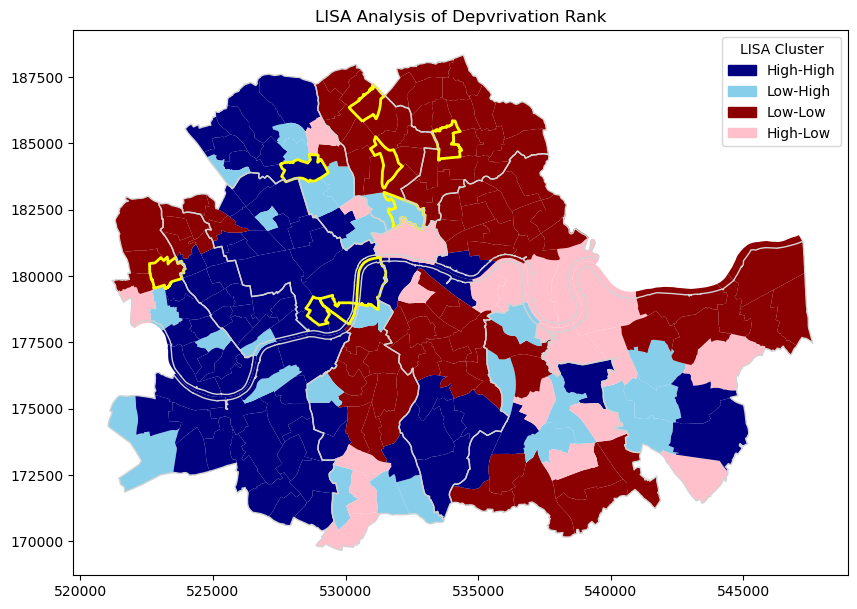

In [35]:
# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(inner_london_wards, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = inner_london_wards['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
inner_london_wards['moran_local'] = lisa.Is
inner_london_wards['p_value'] = lisa.p_sim
inner_london_wards['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
inner_london_wards['significant'] = inner_london_wards['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
inner_london_wards.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = inner_london_wards[inner_london_wards['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)


inner_boroughs.plot(
    edgecolor='lightgrey',    # Set black boundary for at-risk wards
    linewidth=1,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Deprivation Rank')
plt.show()

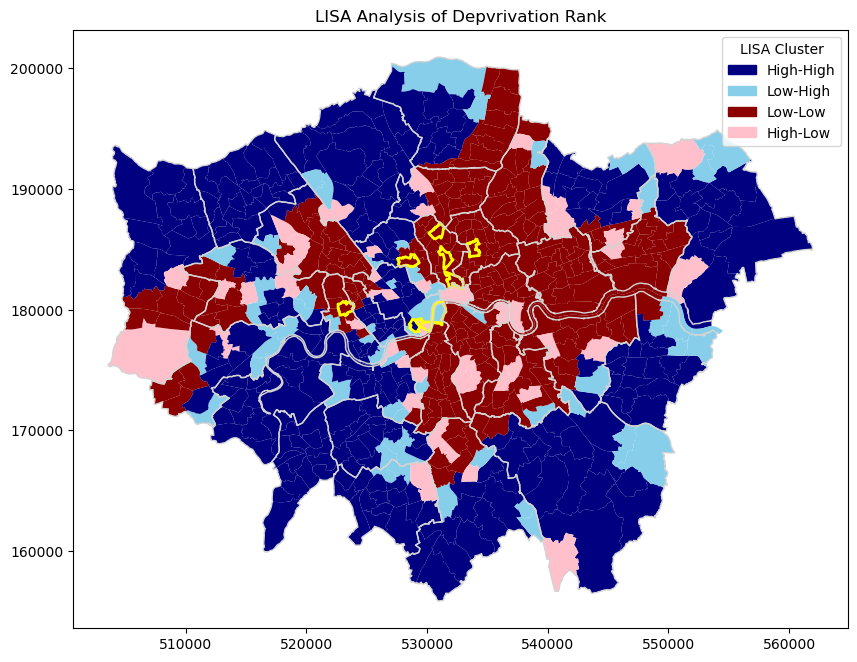

In [21]:
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = inner_london_wards['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = ward_airbnb[ward_airbnb['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Outline the wards with 'at_risk' status
boroughs.plot(
    edgecolor='lightgrey',    # Set black boundary for at-risk wards
    linewidth=1,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Depvrivation Rank')
plt.show()